In [1]:
from sar.utils.factory import sarimage
from sar.transform.sarimage2sarxspec import sarimage2sarxspec
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
dpi = float(matplotlib.rcParams['savefig.dpi'])

# SAR Cutoff Estimation

## Imagette test

In [2]:
# Instantiate reader object
path = '/home/cercache/project/mpc-sentinel1/data/esa/sentinel-1a/L1/WV/S1A_WV_SLC__1S/2015/199/'\
    'S1A_WV_SLC__1SSV_20150718T013216_20150718T015501_006858_0093FB_C717.SAFE/measurement/'\
    's1a-wv2-slc-vv-20150718t014147-20150718t014150-006858-0093fb-040.tiff'
sarim = sarimage(path)
# Compute cross-spectrum
extent = sarim.extent_max()
sarxspec = sarimage2sarxspec(sarim, extent)
# Get azimuth length
azi_spec_size = sarxspec.get_info('azimuth_size')
azi_dk = sarxspec.get_info('azimuth_dk')
azi_delta = 2. * np.pi / azi_dk / azi_spec_size
azi_length = fftshift(fftfreq(azi_spec_size, d=1) * azi_spec_size) * azi_delta

## Get azimuthal cross covariance profile


In [3]:
# Get covariance of shortest time lag (tau=1)
ccs = sarxspec.get_data(tau=1)
ccc = fftshift(ifft2(ifftshift(ccs))).real
# Get azimuthal profile
_, range_index = np.unravel_index(ccc.argmax(), ccc.shape)
profile = ccc[:, range_index]
profile /= profile.max()

## Show

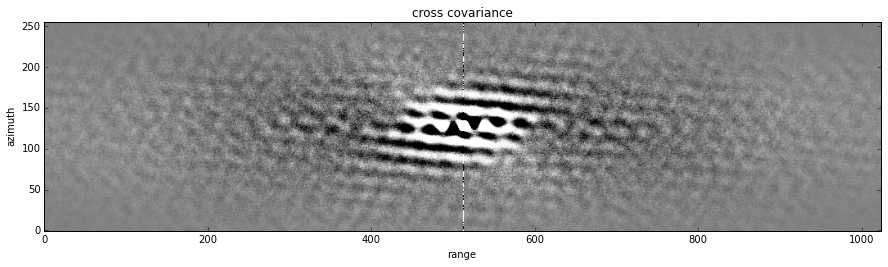

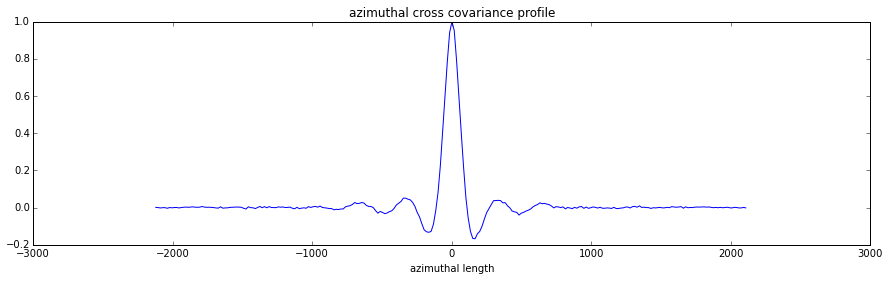

In [4]:
# Show covariance image
plt.figure(figsize=(15, 15))
vmin, vmax = np.percentile(ccc, [1, 99])
plt.imshow(ccc, cmap=plt.cm.Greys_r, origin='lower', vmin=vmin, vmax=vmax)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('cross covariance')
# Show profile
plt.figure(figsize=(15, 4))
plt.plot(azi_length, profile)
plt.xlabel('azimuthal length')
plt.title('azimuthal cross covariance profile')

## Simple profile fit

In [5]:
# Define the fit function
def fit(length, _lambda):
    return np.exp(-((np.pi ** 2) * (length ** 2)) / (_lambda ** 2))
# Fit for lambda estimation
popt, pcov = curve_fit(fit, azi_length, profile, 250.)
_lambda = popt[0]
print 'Estimated azimuth cutoff : {:.2f} meters'.format(_lambda)
if os.path.basename(path) == 's1a-wv2-slc-vv-20150718t014147-20150718t014150-006858-0093fb-040.tiff':
    print '(azimuth cutoff in S1 L2 product : 221 meters)'

Estimated azimuth cutoff : 207.56 meters
(azimuth cutoff in S1 L2 product : 221 meters)


## Show

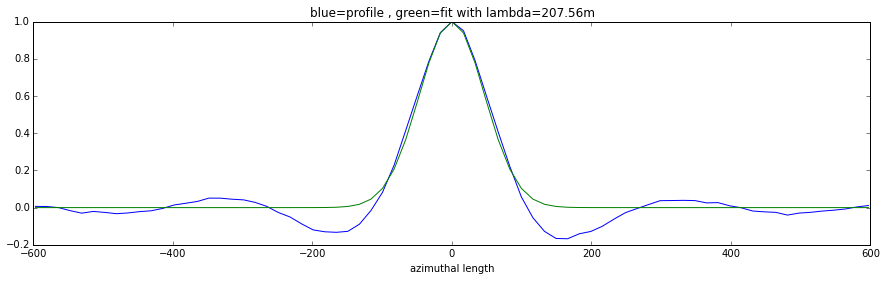

In [6]:
# Plot zoomed profile and fitted exponential
zoom = np.where(abs(azi_length) < 600)
plt.figure(figsize=(15, 4))
plt.plot(azi_length[zoom], profile[zoom], 'b')
plt.plot(azi_length[zoom], fit(azi_length[zoom], _lambda), 'g')
plt.xlabel('azimuthal length')
plt.title('blue=profile , green=fit with lambda={:.2f}m'.format(_lambda))